In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# first we will Load the file 
parcels = gpd.read_file("land_parcels.shp")

# confirming if the data is imported without any issue
print(parcels.head())

   parcel_id  carbon_sto         cost  \
0          0   57.050444  4706.178160   
1          1   28.383328  3722.863104   
2          2   31.481736  2281.036311   
3          3   70.452120  1849.986859   
4          4   38.455948  3883.390216   

                                            geometry  
0  POLYGON ((-95.0285 49.00837, -95.02067 49.0904...  
1  POLYGON ((-94.91661 48.9865, -94.9098 49.12743...  
2  POLYGON ((-94.7894 49.01419, -94.8242 49.07556...  
3  POLYGON ((-94.72478 49.02353, -94.69378 49.120...  
4  POLYGON ((-94.62821 48.99532, -94.58622 49.118...  


In [31]:
# Reproject to a different coordinate system EPSG:3347 (meters) {USED AI MODEL}
parcels = parcels.to_crs("EPSG:3347")

# Calculate area in km²
parcels["area_km2"] = parcels.geometry.area / 1e6  # Convert m² to km²

In [39]:
# Number of polygons
num_polygons = len(parcels)
print(f"Total number of polygons in the provided data set: {num_polygons}")

# Calculating the area by running the methods on the column and storing in the variable
area_minimum = parcels["area_km2"].min()
area_average = parcels["area_km2"].mean()
area_maximum = parcels["area_km2"].max()
print(f"\nArea (km²) is as followed:\nMin={area_minimum:.3f} \nAvg={area_average:.3f} \nMax={area_maximum:.3f}")

# finding the carbon range using the provided methods and storing them in the variables
carbon_min = parcels["carbon_sto"].min()
carbon_max = parcels["carbon_sto"].max()
cost_min = parcels["cost"].min()
cost_max = parcels["cost"].max()
print(f"\nCarbon Store Range: {carbon_min} to {carbon_max}")
print(f"Cost Range: {cost_min} to {cost_max}")

# Confirm CRS after reprojection
print(f"\nCurrent CRS: {parcels.crs}")

Total number of polygons in the provided data set: 100

Area (km²) is as followed:
Min=37.378 
Avg=80.540 
Max=132.096

Carbon Store Range: 10.036534572755878 to 99.8608996768998
Cost Range: 524.9516816211429 to 4982.434015347925

Current CRS: EPSG:3347


In [23]:
# Objective: Maximize total carbon_sto (not carbon_store!)
prob += pulp.lpSum([x[i] * filtered.loc[filtered.parcel_id == i, "carbon_sto"].values[0] for i in x])

In [24]:
# Task 3: Reproject & Filter
# --------------------------

# Reprojecting the data to EPSG:3347 (already done in the code above once )
parcels = parcels.to_crs("EPSG:3347")

# Calculating the area in km² 
parcels["area_km2"] = parcels.geometry.area / 1e6

# Filter out small parcels
# ------------------------------------------------------------------------------
# Given the data shows Min=37.378 km², we need to choose a HIGHER threshold 
# to actually remove outliers. Let's use 50 km² as an example:
area_threshold = 50  # Adjust this based on your needs
filtered = parcels[parcels["area_km2"] >= area_threshold]

print(f"\nFiltering Results (Threshold = {area_threshold} km²):")
print(f"Original parcels: {len(parcels)}")
print(f"Remaining parcels: {len(filtered)}")
print(f"Removed: {len(parcels) - len(filtered)} parcels")

# Save filtered data for later steps
filtered = filtered.reset_index(drop=True)


Filtering Results (Threshold = 50 km²):
Original parcels: 100
Remaining parcels: 95
Removed: 5 parcels


In [41]:
# Task 4: Compute Adjacency (Simpler Method)
# ------------------------------------------

# Performing spatial self-join for finding the adjacent parcels
adjacent_pairs = gpd.sjoin(
    filtered[["parcel_id", "geometry"]], 
    filtered[["parcel_id", "geometry"]], 
    how="inner", 
    predicate="touches"  # Use "intersects" if "touches" misses some edges
)

# Removing duplicate pairs which might have come in the variable in the first  (e.g., (A, B) and (B, A))
adjacent_pairs = adjacent_pairs[
    adjacent_pairs["parcel_id_left"] < adjacent_pairs["parcel_id_right"]
]

# Convert to list of tuples
adjacency = list(zip(adjacent_pairs["parcel_id_left"], adjacent_pairs["parcel_id_right"]))

print(f"\nFound {len(adjacency)} unique adjacent parcel pairs.")



Found 312 unique adjacent parcel pairs.


In [49]:
import pulp

# Initializing the optimization problem as maximization
prob = pulp.LpProblem("Carbon_Storage_Optimization", pulp.LpMaximize)


# 2. Decision Variables
# Creating binary variables for each parcel (1 = selected, 0 = excluded)
# x = {parcel_id: BinaryVariable}
x = pulp.LpVariable.dicts("parcel_selection", 
                         filtered.parcel_id, 
                         cat="Binary")


# 3. Objective Function
# Maximize total carbon storage: summation of (carbon_sto * x_i)
prob += pulp.lpSum(
    x[i] * filtered.loc[filtered.parcel_id == i, "carbon_sto"].values[0]
    for i in x
), "Total_Carbon_Storage"


# 4. Mandatory Constraints

# Constraint 1: Budget Limit (50% of total filtered cost)
# ------------------------------------------------
total_budget = 0.5 * filtered["cost"].sum()
prob += pulp.lpSum(
    x[i] * filtered.loc[filtered.parcel_id == i, "cost"].values[0]
    for i in x
) <= total_budget, "Budget_Constraint"

# Constraint 2: No Adjacent Parcels 
for (i, j) in adjacency:
    prob += x[i] + x[j] <= 1, f"Adjacency_Constraint_{i}_{j}"  



# 6. Solve Optimization
prob.solve()


# 7. Results Analysis
print("\nOptimization Status:", pulp.LpStatus[prob.status])

if pulp.LpStatus[prob.status] == "Optimal":
    # Get selected parcels
    selected_ids = [i for i in x if x[i].varValue == 1]
    selected_parcels = filtered[filtered.parcel_id.isin(selected_ids)]
    
    # Calculate metrics
    total_carbon = selected_parcels["carbon_sto"].sum()
    total_cost = selected_parcels["cost"].sum()
    
    # Display results
    print("\n=== Optimization Results ===")
    print(f"Selected Parcels: {len(selected_parcels)}")
    print(f"Total Carbon Storage: {total_carbon:.2f} tons")
    print(f"Total Cost: ${total_cost:.2f} (Allowed Budget: ${total_budget:.2f})")
    print("\nSelected Parcel IDs:", sorted(selected_ids))
else:
    print("No valid solution found. Check constraints for conflicts.")




Optimization Status: Optimal

=== Optimization Results ===
Selected Parcels: 24
Total Carbon Storage: 1864.94 tons
Total Cost: $63218.09 (Allowed Budget: $134914.57)

Selected Parcel IDs: [0, 2, 6, 9, 14, 20, 22, 26, 29, 34, 40, 46, 49, 52, 54, 60, 67, 69, 73, 75, 81, 88, 93, 96]



--- Final Selection Results ---
Number of Selected Parcels: 24
Total Carbon Stored: 1864.94 tons
Total Implementation Cost: $63218.09
Available Budget: $134914.57 (50% of total potential costs)


C:\Users\naael\AppData\Local\Temp\ipykernel_2292\2301465185.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Parcel Status:")
C:\Users\naael\AppData\Local\Temp\ipykernel_2292\2301465185.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Parcel Status:")


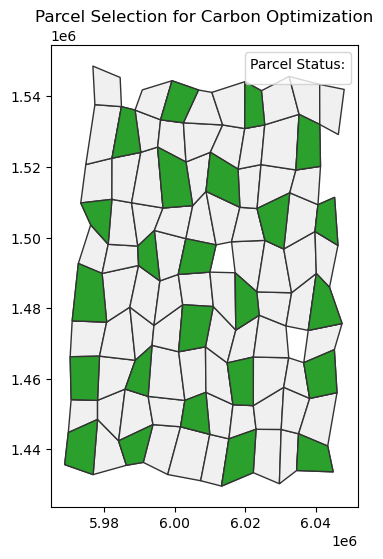

In [50]:
# Task 6: Results & Visualization
# -------------------------------

# Extract IDs of selected parcels based on optimization results
selected_ids = [parcel_id for parcel_id in x if x[parcel_id].varValue == 1]

# Get full details for selected parcels from filtered dataset
selected_parcels = filtered[filtered['parcel_id'].isin(selected_ids)]

# Display optimization results summary
print("\n--- Final Selection Results ---")
print(f"Number of Selected Parcels: {len(selected_parcels)}")
print(f"Total Carbon Stored: {selected_parcels['carbon_sto'].sum():.2f} tons")
print(f"Total Implementation Cost: ${selected_parcels['cost'].sum():.2f}")
print(f"Available Budget: ${total_budget:.2f} (50% of total potential costs)")

# Create comparison map of selected vs. non-selected parcels
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all parcels in neutral color
filtered.plot(
    ax=ax,
    color='#f0f0f0',  # Light gray
    edgecolor='#333333',  # Dark gray border
    label='Non-selected Parcels'
)

# Highlight selected parcels in green
selected_parcels.plot(
    ax=ax,
    color='#2ca02c',  # Professional green
    edgecolor='#333333',
    label='Selected Parcels'
)

# Finalize visualization
plt.title("Parcel Selection for Carbon Optimization")
plt.legend(title="Parcel Status:")
plt.show()